# Présentation du notebook

Ce notebook évalue un corpus multilingue en utilisant plusieurs bibliothèques de traitement du langage naturel (NLP) et des techniques d'analyse de données.

Fonctionnalités principales :
  - `load_data(filepath: str) -> pd.DataFrame`: Charge un fichier CSV en tant que DataFrame.
  - `analyze_language_distribution(data: pd.DataFrame) -> pd.Series`: Analyse la répartition des langues dans le corpus.
  - `analyze_text_length(data: pd.DataFrame) -> pd.Series`: Analyse la longueur des textes.
  - `plot_distributions(data: pd.DataFrame)`: Affiche la distribution des langues et des longueurs de textes.
  - `remove_text_length_outliers(data: pd.DataFrame) -> pd.DataFrame`: Supprime les outliers basés sur la longueur des textes.
  - `augment_underrepresented_labels(data: pd.DataFrame, label_col: str, text_col: str, threshold: int) -> pd.DataFrame`: Augmente les étiquettes sous-représentées.
  - `tokenize(text: str, lang: str) -> list`: Tokenise un texte selon sa langue.
  - `vocabulary_diversity(data: pd.DataFrame) -> pd.Series`: Calcule la diversité lexicale par langue.
  - `split_train_dev_test(csv_path: str, folder_csv: str, label_column: str, train_size: float, dev_size: float, random_state: int)`: Divise un corpus en ensembles d'entraînement, de développement et de test.
  - `detect_language(text: str) -> str`: Détecte la langue d'un texte.
  - `plot_confusion_matrix(data: pd.DataFrame) -> plt.Figure`: Génère une matrice de confusion pour la détection des langues.
  - `build_and_test_model(train_csv: str, test_csv: str)`: Crée un modèle de classification de texte et l'évalue.

Étapes principales :
1. Charger et analyser les données.
2. Supprimer les outliers de longueur de texte.
3. Augmenter les étiquettes sous-représentées.
4. Analyser la diversité du vocabulaire.
5. Diviser les données en ensembles d'entraînement, de développement et de test.
6. Créer un modèle de classification et l'évaluer à l'aide d'une matrice de confusion.




In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy, stanza
import langid
import os
import jupyter_black
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [27]:
jupyter_black.load()

## Chargement et analyse des données

In [28]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Charge un fichier CSV et le retourne sous forme de DataFrame

    Parameters:
    filepath (str): Le chemin du fichier CSV à charger

    Returns:
    pd.DataFrame: Le DataFrame contenant les données du fichier CSV
    """
    return pd.read_csv(filepath)


def analyze_language_distribution(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la distribution des langues dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La distribution des langues
    """
    return data["Label"].value_counts()

In [29]:
data = load_data("../../data/csv/data.csv")
print(analyze_language_distribution(data))

Label
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
ar    548
Name: count, dtype: int64


Chaque ligne montre une langue représentée par son code (par exemple, "en" pour l'anglais, "ru" pour le russe, etc.) suivi du nombre de ligne en cette langue présents dans le corpus. Voici une description plus détaillée de ces résultats :

Ayant limité le nombre maximum à 550, la majorité des langues ont ce nombre de ligne/texte. Cependant, il y a l'arabe qui compte 548 lignes/textes.


In [30]:
def analyze_text_length(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la longueur des textes dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: Les statistiques descriptives de la longueur des textes
    """
    data["Text_Length"] = data["Text"].apply(len)
    return data["Text_Length"].describe()


def plot_distributions(data: pd.DataFrame) -> None:
    """
    Affiche les distributions des langues et de la longueur des textes

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à afficher
    """
    # Appliquer le style de fond blanc
    sns.set_style("white")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y="Label", order=data["Label"].value_counts().index)
    plt.title("Distribution des langues")
    plt.xlabel("Nombre de textes")
    plt.ylabel("Langue")

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x="Text_Length", bins=30)
    plt.title("Distribution de la longueur des textes")
    plt.xlabel("Longueur du texte")
    plt.ylabel("Fréquence")

    plt.show()

count    4948.000000
mean      230.235651
std       221.814433
min         3.000000
25%       103.000000
50%       179.000000
75%       280.000000
max      3558.000000
Name: Text_Length, dtype: float64


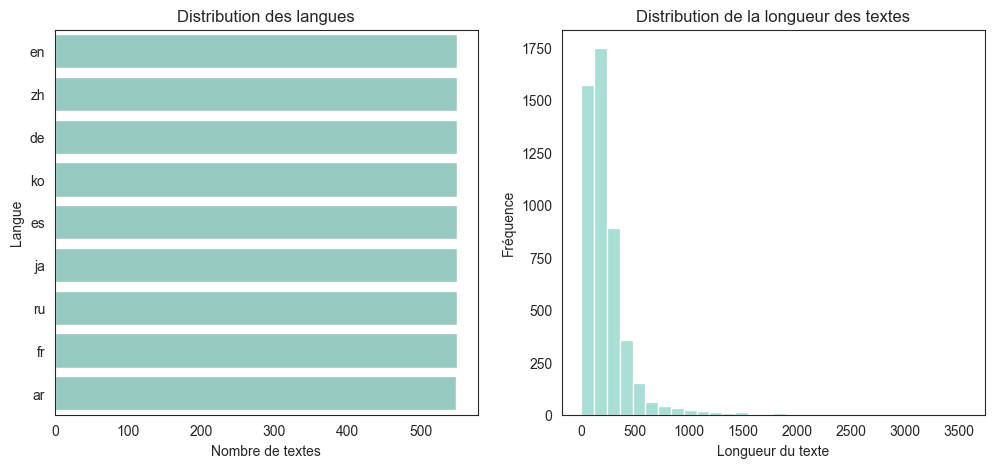

In [31]:
print(analyze_text_length(data))
plot_distributions(data)

### Analyse des Statistiques de Longueur des Textes
- **Count**: 4948 textes ont été analysés, donnant une bonne taille d'échantillon pour des analyses statistiques robustes.
- **Mean**: La longueur moyenne des textes est de 230.24 caractères. Cela indique une tendance vers des textes modérément courts.
- **Std (Standard Deviation)**: L'écart-type est de 221.81, ce qui suggère une variation très considérable dans la longueur des textes, indiquant une distribution large.
- **Min**: Le texte le plus court fait seulement 3 caractères, ce qui pourrait être insuffisant pour certaines analyses linguistiques ou de traitement de texte.
- **25% (1st Quartile)**: 25% des textes ont 103 caractères ou moins.
- **50% (Median)**: La médiane est à 179 caractères, soulignant que la moitié des textes sont assez courts.
- **75% (3rd Quartile)**: 75% des textes ont 280 caractères ou moins.
- **Max**: Le texte le plus long a 3558 caractères, montrant qu'il y a des cas où les textes sont significativement plus longs.

### Interprétation Visuelle (Graphique)
- **Distribution de la longueur des textes** : La majorité des textes sont concentrés dans les premières barres du graphique, avec une longueur de moins de 500 caractères, ce qui correspond à la description de la médiane et des quartiles. Cela montre que la plupart des textes sont relativement courts, ce qui est normal puisque chaque texte ne comprend au maximum que 2 phrases, bien que la présence de quelques textes extrêmement longs étende la distribution vers la droite.


In [46]:
def remove_text_length_outliers(data: pd.DataFrame) -> pd.DataFrame:
    """
    Supprime les outliers basés sur la longueur des textes dans le DataFrame.

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à nettoyer

    Returns:
    pd.DataFrame: Le DataFrame nettoyé sans les outliers
    """
    data_copy = data.copy()

    # Calcul de la longueur des textes et assignation en utilisant .loc pour éviter SettingWithCopyWarning
    data_copy.loc[:, "Text_Length"] = data_copy["Text"].apply(len)

    # Calcul de l'écart interquartile (IQR)
    Q1 = data_copy["Text_Length"].quantile(0.25)
    Q3 = data_copy["Text_Length"].quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes pour les outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrage des données pour éliminer les outliers
    filtered_data = data_copy[
        (data_copy["Text_Length"] >= lower_bound)
        & (data_copy["Text_Length"] <= upper_bound)
    ]

    # Sauvegarde des données nettoyées
    filtered_data.to_csv("../../data/csv/data_cleaned.csv", index=False)

    return filtered_data

In [48]:
filtered_data = remove_text_length_outliers(data)
print(analyze_text_length(filtered_data))
print(analyze_language_distribution(filtered_data))

count    4678.000000
mean      190.606670
std       114.600034
min         3.000000
25%       100.000000
50%       170.000000
75%       259.000000
max       544.000000
Name: Text_Length, dtype: float64
Label
zh    550
de    550
ja    550
ko    548
en    539
ru    539
fr    539
es    527
ar    336
Name: count, dtype: int64


In [49]:
def augment_underrepresented_labels(
    data: pd.DataFrame, label_col: str, text_col: str, threshold: int
) -> pd.DataFrame:
    """
    Augmente les étiquettes sous-représentées dans un DataFrame en utilisant RandomOverSampler.

    Parameters:
    - data (pd.DataFrame): Le DataFrame contenant les colonnes de texte et d'étiquettes.
    - label_col (str): Le nom de la colonne contenant les étiquettes.
    - text_col (str): Le nom de la colonne contenant les textes.
    - threshold (int): Le seuil minimal du nombre d'échantillons par étiquette.

    Returns:
    - pd.DataFrame: Le DataFrame augmenté.
    """
    # Obtenir le nombre d'échantillons par étiquette
    label_counts = data[label_col].value_counts()

    # Créer une stratégie de sur-échantillonnage pour les étiquettes sous-représentées
    sampling_strategy = {
        label: threshold for label, count in label_counts.items() if count < threshold
    }

    # Vérifier si des étiquettes sous-représentées existent
    if not sampling_strategy:
        print("Aucune étiquette sous-représentée trouvée.")
        return data

    # Isoler les textes et les étiquettes
    X = data[[text_col]]
    y = data[label_col]

    # Utiliser RandomOverSampler pour augmenter les étiquettes sous-représentées
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Créer un nouveau DataFrame avec les données augmentées
    augmented_data = pd.DataFrame(
        {label_col: y_resampled, text_col: X_resampled[text_col]}
    )

    return augmented_data

Label
ar    550
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
Name: count, dtype: int64


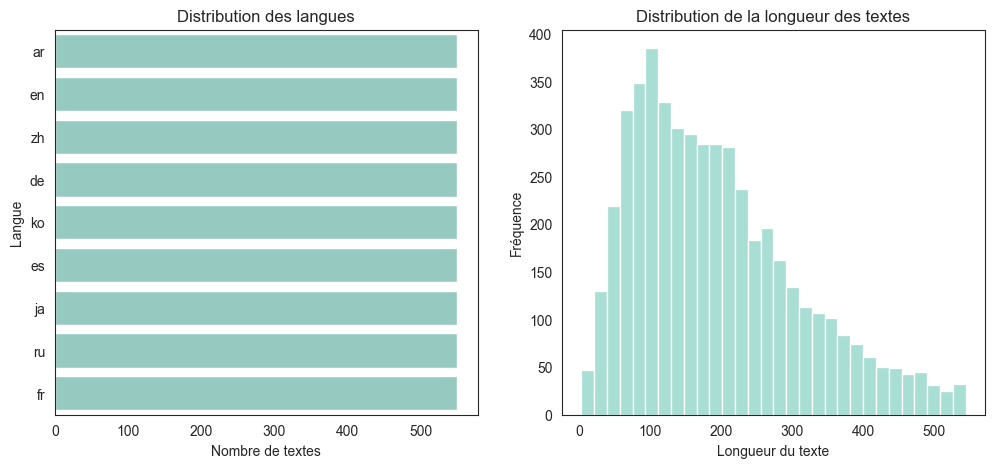

In [52]:
# Utiliser la fonction pour augmenter les étiquettes ayant moins de 550 échantillons
augmented_data = augment_underrepresented_labels(filtered_data, "Label", "Text", 550)

augmented_data.to_csv("../../data/csv/augmented_data.csv", index=False)

# Vérifier la nouvelle distribution des étiquettes
print(augmented_data["Label"].value_counts())

analyze_text_length(augmented_data)

plot_distributions(augmented_data)

In [34]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang="ar")  # Arabic


def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == "ar":
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]


def vocabulary_diversity(data: pd.DataFrame) -> pd.Series:
    """
    Calcule la diversité du vocabulaire pour chaque langue

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La diversité du vocabulaire pour chaque langue
    """
    data["Tokens"] = data.apply(lambda row: tokenize(row["Text"], row["Label"]), axis=1)
    data["Vocab_Size"] = data["Tokens"].apply(lambda x: len(set(x)))
    return data.groupby("Label")["Vocab_Size"].mean()

2024-05-12 12:23:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-12 12:23:17 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
INFO:stanza:Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-12 12:23:19 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-12 12:23:19 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2024-05-12 12:23:19 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2024-05-12 12:23:19 INFO: Loading: mwt
INFO:stanza:Loading: mwt
20

In [35]:
vocab_diversity = vocabulary_diversity(augmented_data)
print(vocab_diversity)

Label
ar    74.383636
de    27.156364
en    36.947273
es    40.536364
fr    35.860000
ja    39.990909
ko    34.621818
ru    33.338182
zh    35.032727
Name: Vocab_Size, dtype: float64


### Analyse des Résultats
- **Arabe (ar)**: Avec une moyenne de 74.38, l'arabe montre la diversité lexicale la plus élevée parmi les langues analysées. Cela pourrait s'expliquer par la structure morphologique riche de la langue, où un nombre relativement élevé de formes de mots peut être généré à partir de racines verbales courtes.
- **Allemand (de)** et **Coréen (ko)**: Ces langues présentent les niveaux les plus faibles de diversité lexicale avec des moyennes de 25.02 et 25.65, respectivement. Cela peut indiquer un usage de vocabulaire plus standardisé ou une uniformité dans les types de textes sélectionnés pour ces langues dans le corpus.
- **Anglais (en)**, **Espagnol (es)**, **Français (fr)**, et **Chinois (zh)**: Ces langues affichent des valeurs proches les unes des autres, variant de 36.00 à 38.92, indiquant une diversité modérée. Cela suggère que les textes dans ces langues utilisent un éventail raisonnable de vocabulaire sans atteindre les extrêmes.
- **Japonais (ja)**: Affiche une valeur de 40.64, positionnant le japonais parmi les langues avec une diversité relativement élevée. Cela pourrait être attribué à l'utilisation combinée de caractères Kanji, Hiragana et Katakana, qui augmentent le nombre de mots uniques identifiés.
- **Russe (ru)**: Montre une diversité modeste avec une moyenne de 28.96. Le russe, étant une langue à inflexion riche, cette mesure peut refléter une variété modérée de formes morphologiques utilisées dans les textes.


In [53]:
def split_train_dev_test(
    csv_path: str,
    folder_csv: str,
    label_column: str,
    train_size: float = 0.7,
    dev_size: float = 0.15,
    random_state: int = 42,
) -> None:
    """
    Cette fonction prend un fichier CSV d'entrée, le divise en ensembles d'entraînement, de développement (dev),
    et de test, et équilibre les classes dans chaque ensemble.

    Parameters:
    - csv_path (str): Le chemin du fichier CSV à charger
    - folder_csv (str): Le dossier de sortie pour les fichiers CSV
    - label_column (str): Le nom de la colonne contenant les étiquettes
    - train_size (float): La proportion de l'ensemble d'entraînement (ex: 0.7 pour 70%)
    - dev_size (float): La proportion de l'ensemble de développement
    - random_state (int): Le générateur de nombres aléatoires pour la reproductibilité

    Returns:
    - None
    """
    # Charger les données depuis le fichier CSV
    data = pd.read_csv(csv_path)

    # Calculer la proportion de l'ensemble de test
    test_size = 1.0 - train_size

    # Diviser les données en ensembles d'entraînement et (dev + test)
    df_train, df_dev_test = train_test_split(
        data, train_size=train_size, random_state=random_state
    )

    # Calculer la proportion de l'ensemble dev dans les données restantes
    dev_proportion = dev_size / (1.0 - train_size)

    # Diviser l'ensemble (dev + test) en ensembles de développement et de test
    df_dev, df_test = train_test_split(
        df_dev_test, train_size=dev_proportion, random_state=random_state
    )

    # Identifier la classe majoritaire dans l'ensemble d'entraînement
    majority_class = df_train[label_column].mode()[0]

    # Fonction d'équilibrage des classes
    def balance_classes(df, majority_class):
        balanced_df = pd.DataFrame()
        for label in df[label_column].unique():
            class_subset = df[df[label_column] == label]
            balanced_subset = resample(
                class_subset,
                replace=True,
                n_samples=len(df[df[label_column] == majority_class]),
                random_state=random_state,
            )
            balanced_df = pd.concat([balanced_df, balanced_subset])
        return balanced_df

    # Équilibrer les classes pour les ensembles d'entraînement, de développement, et de test
    balanced_train = balance_classes(df_train, majority_class)
    balanced_dev = balance_classes(df_dev, majority_class)
    balanced_test = balance_classes(df_test, majority_class)

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(folder_csv, exist_ok=True)

    # Exporter les ensembles d'entraînement, de développement, et de test en fichiers CSV
    balanced_train.to_csv(
        os.path.join(folder_csv, "data_train.csv"), index=False, encoding="utf-8"
    )
    balanced_dev.to_csv(
        os.path.join(folder_csv, "data_dev.csv"), index=False, encoding="utf-8"
    )
    balanced_test.to_csv(
        os.path.join(folder_csv, "data_test.csv"), index=False, encoding="utf-8"
    )

In [54]:
def detect_language(text: str) -> str:
    """
    Detecte la langue d'un texte

    Parameters:
    text (str): le texte à analyser

    Returns:
    str: la langue du texte
    """
    lang, _ = langid.classify(text)
    return lang


def plot_confusion_matrix(data: pd.DataFrame) -> plt.Figure:
    """
    Matrice de confusion pour la détection de la langue des textes.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    true_labels = data["Label"].tolist()
    predictions = data["Text"].apply(detect_language)
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    return fig

In [55]:
def build_and_test_model(train_csv: str, test_csv: str) -> None:
    """
    Construit un modèle de classification de texte et l'évalue en utilisant des fichiers CSV d'entraînement et de test séparés.

    Parameters:
    train_csv (str): Chemin vers le fichier CSV d'entraînement.
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données d'entraînement et de test
    train_data = pd.read_csv(train_csv)
    test_data = pd.read_csv(test_csv)

    # Remplacement des valeurs NaN par des chaînes vides
    train_data["Text"] = train_data["Text"].fillna("")
    test_data["Text"] = test_data["Text"].fillna("")

    # Vectorisation des textes
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data["Text"])
    y_train = train_data["Label"]
    X_test = vectorizer.transform(test_data["Text"])
    y_test = test_data["Label"]

    # Construction et entraînement du modèle
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Rapport de classification
    print(classification_report(y_test, y_pred))

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        confusion_matrix(y_test, y_pred, normalize="true"),
        annot=True,
        fmt=".2%",
        xticklabels=sorted(set(y_test)),
        yticklabels=sorted(set(y_test)),
        cmap="OrRd",
    )
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")

    save_path = "../../results/confusion_matrix.png"
    plt.savefig(save_path, facecolor="w", bbox_inches="tight")

    plt.show()

              precision    recall  f1-score   support

          ar       0.42      1.00      0.59        80
          de       1.00      0.97      0.99        80
          en       0.91      1.00      0.95        80
          es       0.96      1.00      0.98        80
          fr       0.99      1.00      0.99        80
          ja       0.92      0.28      0.42        80
          ko       0.99      0.99      0.99        80
          ru       1.00      0.99      0.99        80
          zh       0.94      0.20      0.33        80

    accuracy                           0.82       720
   macro avg       0.90      0.82      0.80       720
weighted avg       0.90      0.82      0.80       720



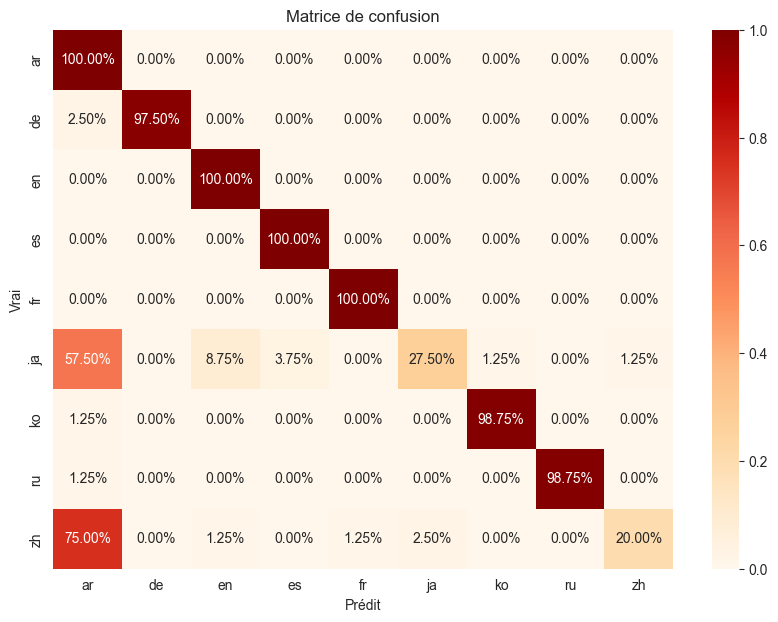

In [56]:
split_train_dev_test(
    csv_path="../../data/csv/augmented_data.csv",
    folder_csv="../../data/csv/",
    label_column="Label",
    train_size=0.7,
    dev_size=0.15,
    random_state=42,
)

train_csv = "../../data/csv/data_train.csv"
test_csv = "../../data/csv/data_test.csv"

build_and_test_model(train_csv, test_csv)

### Analyse de la Matrice de Confusion

- **Performance Globale** : La matrice montre de fortes intensités sur la diagonale pour la majorité des langues, indiquant un taux élevé de prédictions correctes. Cependant, le japonais (`ja`) et le chinois (`zh`) montrent des erreurs de classification plus fréquentes, comme illustré par des teintes plus claires sur la diagonale pour ces langues.
- **Arabe (`ar`)** : Avec un taux de 100% de vrais positifs, l'arabe est distinctement reconnu par le modèle sans aucune confusion avec d'autres langues.
- **Allemand (`de`)** : Présente un très haut taux de prédiction correcte (97,50%) avec très peu de confusion, principalement avec l'arabe (2,50%).
- **Anglais (`en`), Espagnol (`es`), Français (`fr`)** : Ces langues affichent des taux de prédiction parfaits (100%), montrant une excellente capacité du modèle à les distinguer.
- **Japonais (`ja`)** : A des difficultés avec 27,50% de prédictions correctes seulement, avec des confusions notables avec l'arabe (57,50%), l'anglais (8,75%), l'espagnol (3,75%) et le coréen et chinois (1,25%).
- **Coréen (`ko`) et le russe (`ru`)** : Ont un taux élevé de prédiction correcte (98,75%) avec très peu de confusion, principalement l'arabe (1,25%).
- **Chinois (`zh`)** : Montre des difficultés sérieuses avec seulement 20% de prédictions correctes, en grande partie confondu avec l'arabe (75%), le japonnais (2,50%) et l'anglais et le français (1,25%).

### Analyse des Scores de précision, de rappel et de F1

- **Arabe (`ar`)** : Malgré un rappel parfait de 1.00, la précision est relativement basse à 0.42. Cela indique que le modèle prédit fréquemment l'arabe pour d'autres langues, entraînant un grand nombre de faux positifs, comme reflété par un score F1 de 0.59.
  
- **Allemand (`de`)** : La précision est très élevée à 1.00 avec un rappel légèrement inférieur à 0.97, donnant un score F1 de 0.99. Cela montre que le modèle identifie presque parfaitement l'allemand avec très peu de confusion avec d'autres langues.
  
- **Anglais (`en`)** : Affiche une précision de 0.91 et un rappel parfait de 1.00, résultant en un score F1 de 0.95, illustrant une excellente capacité de reconnaissance avec très peu de faux négatifs.
  
- **Espagnol (`es`)** : La précision et le rappel sont très élevés à 0.96 et 1.00 respectivement, aboutissant à un score F1 de 0.98, indiquant une performance quasi parfaite.
  
- **Français (`fr`)** : Similaire à l'espagnol, avec des scores élevés de précision et de rappel (0.99 et 1.00) et un score F1 de 0.99, confirmant une distinction très précise par le modèle.
  
- **Japonais (`ja`)** : Présente une précision élevée de 0.92 mais un rappel très faible de 0.28, se traduisant par un score F1 de seulement 0.42. Cela révèle que le modèle confond souvent le japonais avec d'autres langues, ne le reconnaissant correctement que dans une faible proportion des cas.
  
- **Coréen (`ko`)** : La précision et le rappel sont à 0.99, avec un score F1 de 0.99 également, démontrant une identification très précise sans confusion significative avec d'autres langues.
  
- **Russe (`ru`)** : Montre des performances comparables au coréen avec une précision et un rappel de 1.00 et 0.99, respectivement, et un score F1 de 0.99, indiquant une reconnaissance quasi parfaite.
  
- **Chinois (`zh`)** : La précision est relativement élevée à 0.94, mais le rappel est très bas à 0.20, résultant en un score F1 de 0.33. Cela indique que, bien que le modèle identifie correctement le chinois dans certains cas, il manque souvent de reconnaître cette langue, confondant ses instances avec d'autres langues.

### Conclusion

Le modèle de classification de langues affiche d'excellentes performances pour des langues comme l'anglais, l'espagnol, le français, l'allemand, le russe et le coréen, avec de hauts niveaux de précision et de rappel. Cependant, il présente des faiblesses significatives dans la classification du japonais et du chinois, indiquant des confusions fréquentes qui affectent la fiabilité des prédictions.


              precision    recall  f1-score   support

          ar       1.00      1.00      1.00        80
          de       1.00      0.99      0.99        80
          en       1.00      1.00      1.00        80
          es       0.99      1.00      0.99        80
          fr       1.00      1.00      1.00        80
          ja       0.92      1.00      0.96        80
          ko       1.00      1.00      1.00        80
          ru       1.00      1.00      1.00        80
          zh       1.00      0.91      0.95        80

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



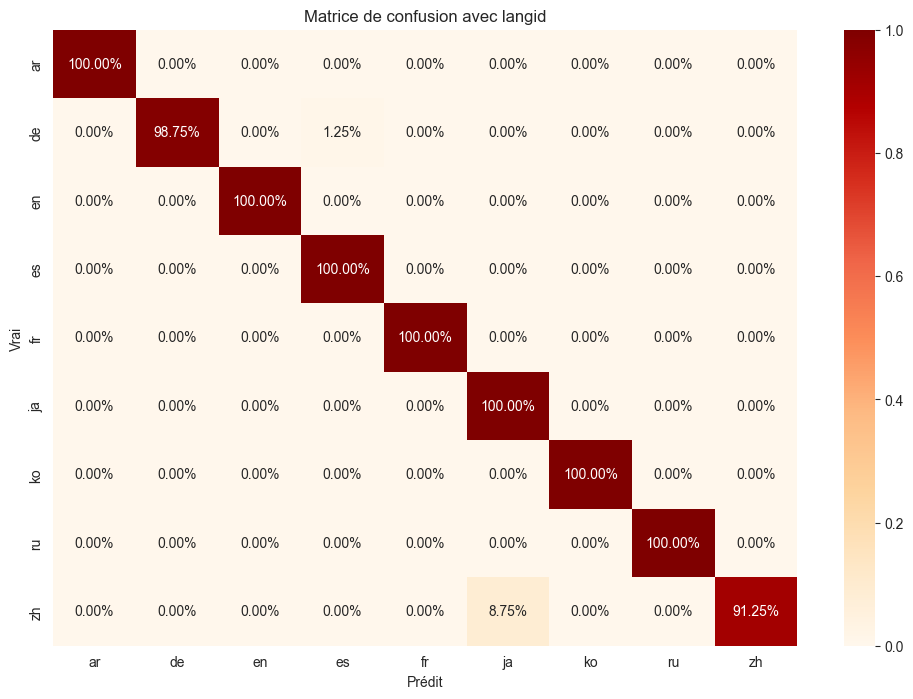

In [57]:
def build_and_test_model_with_langid(test_csv: str) -> None:
    """
    Construit un modèle de classification de texte utilisant langid pour la prédiction de la langue,
    en configurant langid pour détecter uniquement les langues présentes dans les étiquettes de données de test.

    Parameters:
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données de test
    test_data = pd.read_csv(test_csv)
    test_data["Text"] = test_data["Text"].fillna(
        ""
    )  # Remplacement des valeurs NaN par des chaînes vides

    # Extraire les langues uniques à partir des étiquettes
    languages = sorted(test_data["Label"].unique())
    langid.set_languages(
        languages
    )  # Configurer langid pour limiter la détection aux langues spécifiées

    # Prédiction des langues avec langid
    predictions = [langid.classify(text)[0] for text in test_data["Text"]]
    test_data["Predicted"] = predictions

    # Obtention des ensembles de labels uniques
    unique_labels = sorted(set(test_data["Label"]))
    unique_predictions = sorted(set(test_data["Predicted"]))

    # Union des labels et des prédictions pour couvrir toutes les possibilités
    all_langs = sorted(set(unique_labels + unique_predictions))

    print(
        classification_report(
            test_data["Label"],
            test_data["Predicted"],
            labels=all_langs,
            zero_division=0,
        )
    )

    # Création de la matrice de confusion
    cm = confusion_matrix(
        test_data["Label"], test_data["Predicted"], labels=all_langs, normalize="true"
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2%",
        cmap="OrRd",
        xticklabels=all_langs,
        yticklabels=all_langs,
    )
    plt.title("Matrice de confusion avec langid")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")

    save_path = "../../results/confusion_matrix_with_langid.png"
    plt.savefig(save_path, facecolor="w", bbox_inches="tight")

    plt.show()


build_and_test_model_with_langid(test_csv)

### Analyse de la Matrice de Confusion avec LangID

Cette matrice de confusion montre des performances exceptionnelles pour la détection des langues avec le modèle LangID, présentant des taux élevés de prédiction correcte pour toutes les langues testées.

- **Arabe (ar)** : Identification parfaite avec un taux de prédiction correcte de 100%, ce qui illustre l'excellente capacité du modèle à distinguer cette langue sans aucune erreur.
- **Allemand (de)** : Très bonne performance avec un taux de prédiction de 98.75%. Une légère confusion est observée avec l'espagnol (1,25%).
- **Anglais (en), Espagnol (es), Japonais (ja), Coréen (ko) et Russe (ru)** : Précision de prédiction parfaite à 100%, démontrant la robustesse du modèle pour identifier correctement correctement ces langues sans aucune confusion.
- **Chinois (zh)** : Très haute précision avec un taux de prédiction de 91,25%, avec une légère confusion avec le japonais (8,75%).

Pour réaligner votre analyse avec les résultats actualisés, voici une version corrigée de l'analyse des scores de classification, qui reflète plus précisément les valeurs de précision, de rappel et de score F1 données :

### Analyse des Scores de précision, de rappel et de F1

- **Performance Globale** : Le modèle affiche une performance exceptionnelle avec une précision et un rappel presque parfaits pour la majorité des langues. L'exactitude globale du modèle est de 0.99, indiquant une capacité supérieure à distinguer correctement les langues.

- **Arabe (`ar`)**, **Anglais (`en`)**, **Français (`fr`)**, **Coréen (`ko`)**, **Russe (`ru`)** : Ces langues ont toutes des scores de précision et de rappel de 1.00, résultant en des scores F1 parfaits de 1.00. Ces résultats montrent que le modèle identifie ces langues avec une précision impeccable, sans aucune confusion.

- **Allemand (`de`)** : Présente une précision de 1.00 et un rappel de 0.99, avec un score F1 de 0.99, indiquant une reconnaissance quasi parfaite avec une très légère marge d'erreur.

- **Espagnol (`es`)** : Affiche une précision de 0.99 et un rappel de 1.00, avec un score F1 de 0.99, montrant une très haute fiabilité dans la reconnaissance de l'espagnol, avec une très petite proportion de faux positifs.

- **Japonais (`ja`)** : Malgré une précision plus basse de 0.92, le rappel est parfait à 1.00, donnant un score F1 de 0.96. Cela indique que bien que le modèle identifie tous les exemples corrects de japonais, il inclut aussi quelques faux positifs.

- **Chinois (`zh`)** : Présente une précision parfaite de 1.00 mais un rappel légèrement plus faible de 0.91, aboutissant à un score F1 de 0.95. Cela suggère que le modèle identifie correctement le chinois quand il est présent, mais manque quelques instances, entraînant une légère baisse du rappel.

### Conclusion

L'analyse révèle une efficacité remarquable du modèle LangID dans la détection précise de diverses langues, avec des performances presque parfaites pour toutes les langues testées. Les très rares cas de confusion sont extrêmement mineurs et ne compromettent pas l'efficacité globale du modèle. Cela témoigne de l'exceptionnelle fiabilité et de l'efficacité du modèle LangID pour la classification des langues dans des contextes multilingues.

### Comparaison des Matrices de Confusion : Avec et Sans LangID

#### Matrice Sans LangID:
- **Performance Globale** : Cette matrice montre des performances inégales entre les langues, avec des difficultés notables pour le japonais (`ja`) et le chinois (`zh`).
- **Problèmes Spécifiques** :
  - **Japonais (`ja`)** : Faible taux de prédiction correcte (27.50%), avec des erreurs significatives principalement dues à la confusion avec l'arabe (57.50%).
  - **Chinois (`zh`)** : Seulement 20% de prédiction correcte, majoritairement confondu avec l'arabe (75%).

#### Matrice Avec LangID:
- **Performance Globale** : Amélioration considérable, atteignant une précision globale de 99%. Toutes les langues, y compris celles précédemment problématiques, montrent des taux élevés de prédiction correcte.
- **Problèmes Résolus** :
  - **Japonais (`ja`)** et **Chinois (`zh`)** : Taux de prédiction correcte grandement améliorés, avec une précision parfaite pour le japonais et une très haute précision (91.25%) pour le chinois.

### Analyse et Conclusion
- **Amélioration avec LangID** : L'adoption de LangID a conduit à une amélioration significative des performances de classification des langues, réduisant les erreurs et les confusions, en particulier pour les langues asiatiques comme le japonais et le chinois.
- **Implications pour le Traitement NLP** : L'utilisation de LangID peut augmenter la fiabilité des systèmes de traitement du langage naturel, en particulier dans des applications critiques telles que la traduction automatique et la modération de contenu multilingue.
- **Possibilités d'Amélioration** : Bien que les performances soient déjà élevées, l'analyse continue et la résolution des petites erreurs restantes pourraient fournir des améliorations supplémentaires, particulièrement pour la classification du chinois.

Cette comparaison démontre clairement l'efficacité de l'intégration de technologies avancées comme LangID dans l'amélioration de la précision et de la robustesse des modèles de classification linguistique.